In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
pd.options.plotting.backend = "plotly"
pd.set_option('display.max_columns', 150, 'display.max_rows', 100, 'display.max_colwidth', 15)
%matplotlib inline

>#  Import Data 

In [2]:
df = pd.read_csv("insurance.csv")
df.head()

,age,sex,bmi,children,smoker,region,expenses
0,19,female,27.9,0,yes,southwest,16884.92
1,18,male,33.8,1,no,southeast,1725.55
2,28,male,33.0,3,no,southeast,4449.46
3,33,male,22.7,0,no,northwest,21984.47
4,32,male,28.9,0,no,northwest,3866.86


In [3]:
df= df.rename(columns= {"expenses":"target"})
df.head(2)

,age,sex,bmi,children,smoker,region,target
0,19,female,27.9,0,yes,southwest,16884.92
1,18,male,33.8,1,no,southeast,1725.55


In [4]:
target_variable= "target"
all_cols = df.drop(columns="target").columns.tolist()                      
cat_cols = df.drop(columns="target").select_dtypes(["object","category"]).columns.tolist()                      
num_cols= df.drop(columns="target").columns[~df.drop(columns="target").columns.isin(cat_cols)] 

># Column Types

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   target    1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


# Data has no missing values

In [6]:
df.isna().sum()

age         0
sex         0
bmi         0
children    0
smoker      0
region      0
target      0
dtype: int64

In [7]:
df.describe(include= "all")

,age,sex,bmi,children,smoker,region,target
count,1338.000000,1338,1338.000000,1338.000000,1338,1338,1338.000000
unique,NaN,2,NaN,NaN,2,4,NaN
top,NaN,male,NaN,NaN,no,southeast,NaN
freq,NaN,676,NaN,NaN,1064,364,NaN
mean,39.207025,NaN,30.665471,1.094918,NaN,NaN,13270.422414
std,14.049960,NaN,6.098382,1.205493,NaN,NaN,12110.011240
min,18.000000,NaN,16.000000,0.000000,NaN,NaN,1121.870000
25%,27.000000,NaN,26.300000,0.000000,NaN,NaN,4740.287500
50%,39.000000,NaN,30.400000,1.000000,NaN,NaN,9382.030000
75%,51.000000,NaN,34.700000,2.000000,NaN,NaN,16639.915000


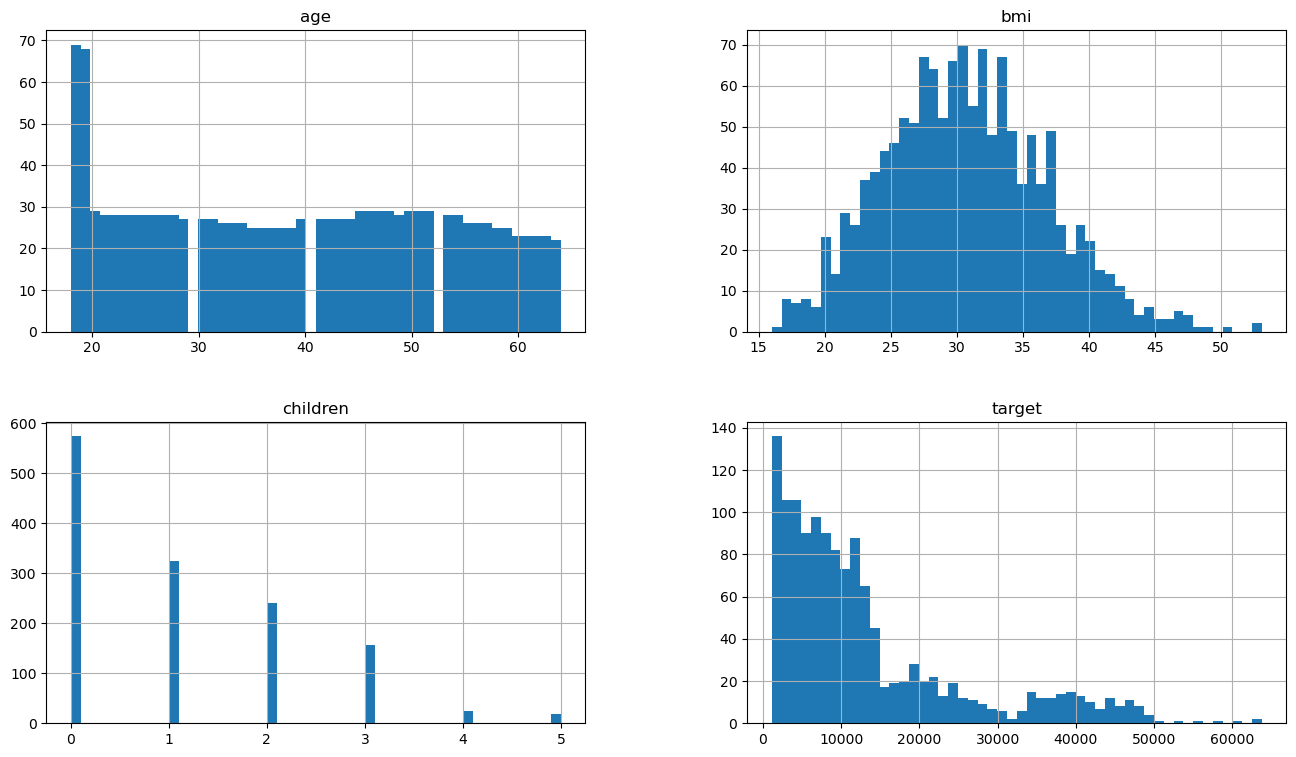

In [8]:
pd.options.plotting.backend = "matplotlib"
df.hist(
    bins=50, 
    figsize=(16,9)   
    )
plt.show()
pd.options.plotting.backend = "plotly"

>#  Custom Mix Immputer class

In [9]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.utils.validation import check_is_fitted # This function just makes sure that the object is fitted
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

class mix_imputer(BaseEstimator, TransformerMixin):
     def __init__(self, impute_missing =True):                                
        self.impute_missing = impute_missing        
                
     def fit(self, X, y = None):         
         return self
 
     def transform(self, X):
        from sklearn.neighbors import KNeighborsRegressor
        from sklearn.ensemble import RandomForestRegressor
        from sklearn.preprocessing import LabelEncoder
        encoder= LabelEncoder()

        X = X.copy()
        cols = X.select_dtypes(["object","category"]).columns.tolist()       
        
        if self.impute_missing:                        
            # we use LabelEncoder bcz it keeps the Nan values of catergories and converts labels (i.e male, female, gay) to 0., 1., 2. floats            
            mapped_dic = {}

            for abc in cols:                
                X[[abc]]=( 
                    X[[abc]].apply(lambda series: pd.Series(
                    encoder.fit_transform(series[series.notnull()]),
                    index=series[series.notnull()].index
                    ))
                    )
                encode_dic= { x: y for x,y in zip ( X[abc][ X[abc].notnull()].unique(), encoder.classes_)}   
                mapped_dic[abc]= encode_dic                 
                        
            # after encoding data apply knn imputer on all the data and fill missing values.            
            imp_knn = IterativeImputer(estimator= RandomForestRegressor(
                n_jobs=-1, 
                #n_neighbors= X.shape[1]
                ), 
                            #initial_strategy='most_frequent',
                            #max_iter=100, 
                            random_state=0)
            
            # imputed values are returned in arrays so convert it back to dataframe
            X = pd.DataFrame(imp_knn.fit_transform(X), columns= X.columns.tolist())               
            
            # round of all categorical columns so that if imputed value is 0.6 it will be converted to 1. instead
            X[cols] = X[cols].round(0).astype("int")
            # now convert all the computed values from 1. , 2. encoding to original labels.    
            
            for abc in cols:
                X[abc] = X[abc].map(mapped_dic[abc])            
            
            # After this step we can again convert the categorical columns to dummies using onehot encoding
        else:
            X = X.copy()
        return X


# Impute missing values

In [10]:
df=  mix_imputer(impute_missing= True).fit_transform(df)
df.head()

,age,sex,bmi,children,smoker,region,target
0,19.0,female,27.9,0.0,no,northeast,16884.92
1,18.0,male,33.8,1.0,yes,northwest,1725.55
2,28.0,male,33.0,3.0,yes,northwest,4449.46
3,33.0,male,22.7,0.0,yes,southeast,21984.47
4,32.0,male,28.9,0.0,yes,southeast,3866.86


In [11]:
import hvplot.pandas
import holoviews as hv
# Look for correlation between all variables and target variable
df_cor= df.corr(numeric_only= True).round(3)
df_cor
p = df_cor.hvplot.heatmap(x="columns", y= "index", rot =45, cmap= "Oranges" , width = 1000, height=400)
p * hv.Labels(p).opts(text_font_size = "8pt")

:Overlay
   .HeatMap.I :HeatMap   [columns,index]   (value)
   .Labels.I  :Labels   [columns,index]   (value)

# Feature Engineering

# **Mean Variable Encoding:**
in mean variable encoding we group the categoriacal variable and measure the mean of some numeric variable.  

In [12]:
df_region=  (
    df.groupby("region", as_index= False)
    .agg(
        mean_region_bmi = ("bmi", "mean"),
        mean_region_age = ("age", "mean"),        
    )
    )
df_region

,region,mean_region_bmi,mean_region_age
0,northeast,30.596615,39.455385
1,northwest,33.359341,38.939560
2,southeast,29.201846,39.196923
3,southwest,29.176235,39.268519


In [13]:
df_smoker=  (
    df.groupby("smoker", as_index= False)
    .agg(
        mean_smoker_bmi = ("bmi", "mean"),
        mean_smoker_age = ("age", "mean"),
        )
    )
df_smoker

,smoker,mean_smoker_bmi,mean_smoker_age
0,no,30.713139,38.514599
1,yes,30.653195,39.385338


In [14]:
df_sex=  (
    df.groupby("sex", as_index= False)
    .agg(
        mean_sex_bmi = ("bmi", "mean"),
        mean_sex_age = ("age", "mean")
        )
    )
df_sex

,sex,mean_sex_bmi,mean_sex_age
0,female,30.379758,39.503021
1,male,30.945266,38.917160


In [15]:
df_num=(
    df.merge(df_region, how="left", on= "region")
    .merge(df_smoker, how="left", on= "smoker")
    .merge(df_sex, how="left", on= "sex")
    .assign(
        obese = lambda df_: np.where( df_.bmi > 30 , 1, 0) ,        
        bmi_cat = lambda df_: pd.cut(df_.bmi ,bins= 10, labels= False).astype("int") ,
        bmi_smoker = lambda df_: df_.bmi_cat.astype(str) +df_.smoker,
        obese_smoker = lambda df_: df_.obese.astype(str) +df_.smoker,
        bmi_age = lambda df_: df_.bmi*df_.age,
        old = lambda df_: np.where( df_.age > 42 , 1, 0) ,
        #old_bmi = lambda df_: df_.old* df_.bmi,        
        old_obese = lambda df_: df_.old* df_.obese,        
        age_childrem= lambda df_: df_.age* df_.children                
    )

).select_dtypes(["int", "float"]).drop(columns = ["bmi","children","old"])+ 1
df_num= df_num#.apply(lambda x: np.log(x))

In [16]:
df= pd.concat([df.select_dtypes("object"), df_num ], axis=1)
df

,sex,smoker,region,age,target,mean_region_bmi,mean_region_age,mean_smoker_bmi,mean_smoker_age,mean_sex_bmi,mean_sex_age,obese,bmi_cat,bmi_age,old_obese,age_childrem
0,female,no,northeast,20.0,16885.92,31.596615,40.455385,31.713139,39.514599,31.379758,40.503021,1,4,531.1,1,1.0
1,male,yes,northwest,19.0,1726.55,34.359341,39.939560,31.653195,40.385338,31.945266,39.917160,2,5,609.4,1,19.0
2,male,yes,northwest,29.0,4450.46,34.359341,39.939560,31.653195,40.385338,31.945266,39.917160,2,5,925.0,1,85.0
3,male,yes,southeast,34.0,21985.47,30.201846,40.196923,31.653195,40.385338,31.945266,39.917160,1,2,750.1,1,1.0
4,male,yes,southeast,33.0,3867.86,30.201846,40.196923,31.653195,40.385338,31.945266,39.917160,1,4,925.8,1,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1333,male,yes,southeast,51.0,10601.55,30.201846,40.196923,31.653195,40.385338,31.945266,39.917160,2,5,1551.0,2,151.0
1334,female,yes,southwest,19.0,2206.98,30.176235,40.268519,31.653195,40.385338,31.379758,40.503021,2,5,575.2,1,1.0
1335,female,yes,northwest,19.0,1630.83,34.359341,39.939560,31.653195,40.385338,31.379758,40.503021,2,6,665.2,1,1.0
1336,female,yes,northeast,22.0,2008.95,31.596615,40.455385,31.653195,40.385338,31.379758,40.503021,1,3,542.8,1,1.0


In [17]:
df.describe()      

,age,target,mean_region_bmi,mean_region_age,mean_smoker_bmi,mean_smoker_age,mean_sex_bmi,mean_sex_age,obese,bmi_cat,bmi_age,old_obese,age_childrem
count,1338.000000,1338.000000,1338.000000,1338.000000,1338.000000,1338.000000,1338.000000,1338.000000,1338.000000,1338.000000,1338.000000,1338.000000,1338.000000
mean,40.207025,13271.422414,31.665471,40.207025,31.665471,40.207025,31.665471,40.207025,1.521674,4.449925,1212.663453,1.249626,44.647235
std,14.049960,12110.011240,1.742138,0.188179,0.024199,0.351512,0.282844,0.293024,0.499717,1.652075,522.676121,0.432959,51.559607
min,19.000000,1122.870000,30.176235,39.939560,31.653195,39.514599,31.379758,39.917160,1.000000,1.000000,289.000000,1.000000,1.000000
25%,28.000000,4741.287500,30.201846,39.939560,31.653195,40.385338,31.379758,39.917160,1.000000,3.000000,766.950000,1.000000,1.000000
50%,40.000000,9383.030000,31.596615,40.196923,31.653195,40.385338,31.945266,39.917160,2.000000,4.000000,1154.250000,1.000000,33.000000
75%,52.000000,16640.915000,34.359341,40.268519,31.653195,40.385338,31.945266,40.503021,2.000000,6.000000,1589.725000,1.000000,73.000000
max,65.000000,63771.430000,34.359341,40.455385,31.713139,40.385338,31.945266,40.503021,2.000000,10.000000,2848.800000,2.000000,261.000000


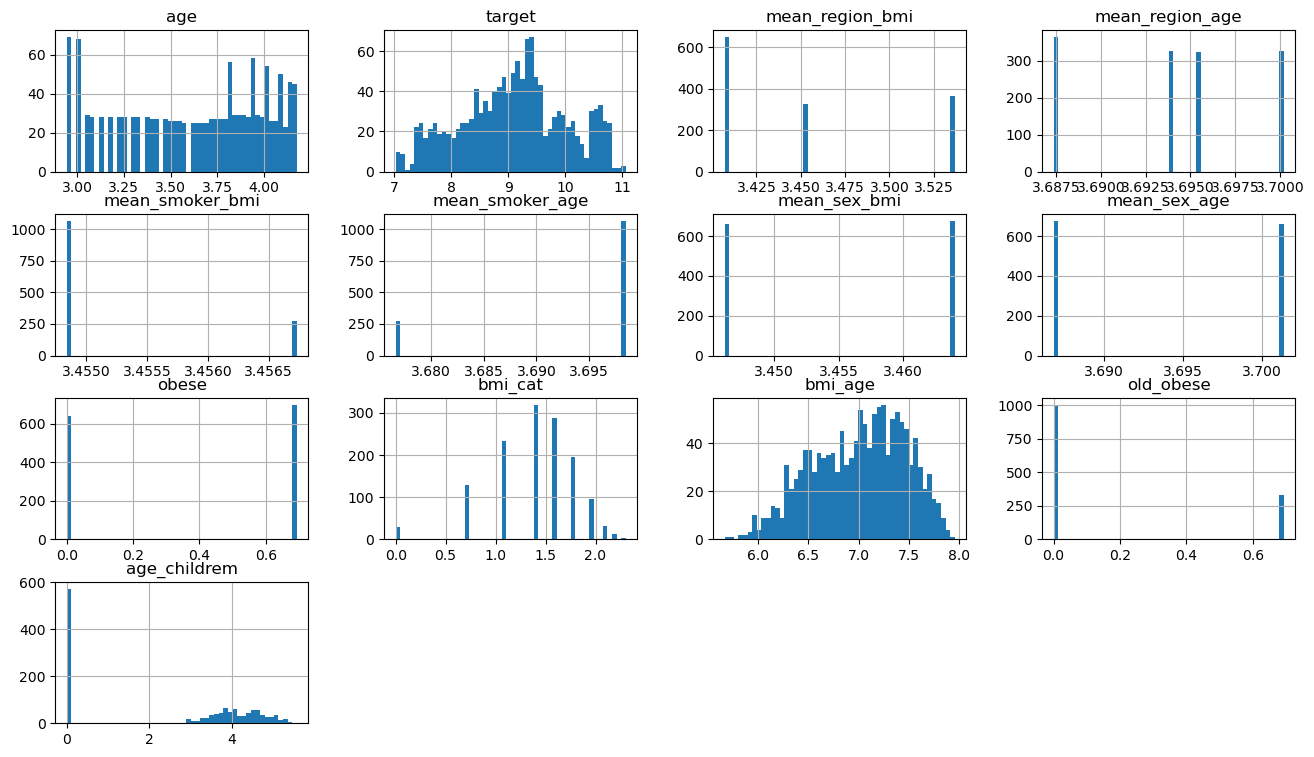

In [18]:
pd.options.plotting.backend = "matplotlib"
df.select_dtypes([int, "float"]).apply(lambda x: np.log(x)).hist(
    bins=50, 
    figsize=(16,9)   
    )
plt.show()
pd.options.plotting.backend = "plotly"

># Correlation

In [20]:
import hvplot.pandas
import holoviews as hv
# Look for correlation between all variables and target variable
df_cor= df.corr(numeric_only= True).round(3)
df_cor
p = df_cor.hvplot.heatmap(x="columns", y= "index", rot =45, cmap= "Oranges" , width = 1000, height=400)
p * hv.Labels(p).opts(text_font_size = "8pt")

:Overlay
   .HeatMap.I :HeatMap   [columns,index]   (value)
   .Labels.I  :Labels   [columns,index]   (value)

># Libraries Preprocess

In [ ]:
# preprocess

from sklearn.pipeline import Pipeline
from imblearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline
from sklearn.compose import ColumnTransformer


# transformer/imputer/scaller/var filter
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import FunctionTransformer
from sklearn.preprocessing import PolynomialFeatures
from sklearn.feature_selection import VarianceThreshold
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import LinearRegression
from sklearn.impute import SimpleImputer
from sklearn.compose import make_column_selector
# Target var Transofrmations
from sklearn.compose import TransformedTargetRegressor

# Library Models/Metrics pipelines

In [ ]:
# Linear Models
from sklearn import linear_model 

#KNN
from sklearn import neighbors

# Tree/Ensemble
from sklearn import tree
from sklearn import ensemble
import xgboost
import lightgbm

#SVM
from sklearn import svm

#Clustering
from sklearn.cluster import KMeans

# metric evaluation and cross validation
from sklearn import metrics
from sklearn.model_selection import cross_validate
from sklearn.model_selection import cross_val_score

># Libraries GRID and sample split

In [ ]:
from sklearn.model_selection import KFold
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV

# Transformers

# **Mean Encoding on Target VAriable**
## Mean Encoding Regularisaiton


in this type of mean encoding the we group the categoriacal variable and measure the mean of target variable.  

Mean encoding should be done after splitting the data. We need to get the means from the training set and map it to test set using join on the category used to groupby. mean of region1 * nrows of region 1 + globalmean(target) * alpha / nrows of region 1 + alpha


In [ ]:
from sklearn.cluster import KMeans
from sklearn.metrics.pairwise import rbf_kernel

class ClusterSimilarity(BaseEstimator, TransformerMixin):
    def __init__(self, n_clusters=10, gamma=1.0, random_state=None):
        self.n_clusters = n_clusters
        self.gamma = gamma
        self.random_state = random_state

    def fit(self, X, y=None, sample_weight=None):
        self.kmeans_ = KMeans(self.n_clusters, random_state=self.random_state)
        self.kmeans_.fit(X, sample_weight=sample_weight)
        return self  # always return self!

    def transform(self, X):
        return rbf_kernel(X, self.kmeans_.cluster_centers_, gamma=self.gamma)
    
    def get_feature_names_out(self, names=None):
        return [f"Cluster {i} similarity" for i in range(self.n_clusters)]

In [ ]:
# Log Transformer
log_transformer =   FunctionTransformer(np.log, inverse_func= np.exp)
# sqrt transformer
sqrt_transformer = FunctionTransformer(np.sqrt, inverse_func= np.square)

# multiplication column
def column_mult(X):    
    return X.iloc[:, 0] * X.iloc[:, 1]
def mult_name(function_transformer, feature_names_in):
    return ["mult"]  # feature names out

def mult_pipeline():
    return make_pipeline(
        SimpleImputer(strategy="median"),
        FunctionTransformer(column_mult, feature_names_out= mult_name),
       StandardScaler()
        )

# Ratio column
def column_ratio(X):    
    return X.iloc[:, 0] / X.iloc[:, 1]

def ratio_name(function_transformer, feature_names_in):
    return ["ratio"]  # feature names out

def ratio_pipeline():
    return make_pipeline(
        SimpleImputer(strategy="median"),
        FunctionTransformer(column_ratio, feature_names_out= ratio_name),
        StandardScaler()
        )

# Create Age Bucket
def age(X):
 return X.iloc[:,[0]].assign(age_cat= lambda df_: pd.cut(df_.housing_median_age ,bins= 10, labels= False).astype("int"))[["age_cat"]]   

age_pipeline = make_pipeline(    
    FunctionTransformer(age, feature_names_out= "one-to-one"),
    StandardScaler()
    )
# Apply Log
log_pipeline = make_pipeline(
    SimpleImputer(strategy="median"),
    FunctionTransformer(np.log, feature_names_out= "one-to-one"),
    StandardScaler()
    )

># Split Data

In [ ]:
from sklearn.model_selection import train_test_split
df_x = df.drop(columns="target").copy()
df_y = df["target"]

X_train, X_test, y_train, y_test =  train_test_split(df_x, df_y, test_size = 0.2, random_state =42)
X_train.shape, y_train.shape, X_test.shape, y_test.shape

># Create function for valuation scores

In [ ]:
def eval_scores(true, predicted):  
    mae = metrics.mean_absolute_error(true, predicted)
    mse = metrics.mean_squared_error(true, predicted)
    rmse = np.sqrt(metrics.mean_squared_error(true, predicted))
    r2_square = metrics.r2_score(true, predicted)
    results= pd.DataFrame(        
        {"mae": [mae], "mse": [mse],"rmse": [rmse],"r2_square": [r2_square]})
    return results

># PIPELINE

># Preprocessor Pipeline

In [ ]:
# seperate columns
all_cols = X_train.columns.tolist()                      
cat_cols = X_train.select_dtypes(["object","category"]).columns.tolist()                      
num_cols= X_train.columns[~X_train.columns.isin(cat_cols)] 
num_cols

In [ ]:
class MeanEncoding(BaseEstimator, TransformerMixin):    
    def __init__(self):        
        self.encoding = pd.DataFrame

    def fit(self, X, y):
        y=y.to_frame()
        # Calculate the mean target value for each category
        self.group_col= X.columns.tolist()[0]
        self.encoding = y[["target"]].groupby(X[self.group_col]).agg(target_mean= ("target", 'mean'))        
        return self
            
    def transform(self, X):
        # Replace the categorical column with the mean encoding   
        X[self.group_col+ "_encoded" ]= X[self.group_col].map(self.encoding["target_mean"])
        return X.drop(self.group_col, axis=1)

    def get_feature_names_out(self, names=None):       
        return [self.group_col+ "_encoded" ]

MeanEncoding().fit_transform(df[["region"]], df["target"])

In [ ]:
mean_encoder_pipe= Pipeline (
        steps =[                 
        ('encoder', MeanEncoding()),
        ("std_scaler", StandardScaler()),                       
                ])
num_pipe= Pipeline (
        steps =[        
        #("minmax" , MinMaxScaler()),        
        ("std_scaler", StandardScaler()),                       
        ("variance_filter", VarianceThreshold(threshold= 0.0001)),                     
                ]
                   )
cat_pipe= Pipeline (
        steps =[        
        ("one_hot", OneHotEncoder (sparse_output=False, drop= "first", handle_unknown= "ignore"))#,
#        ("variance_filter", VarianceThreshold(threshold= 0.1)),                     
                ])
prep = ColumnTransformer([                  
        #("c", cat_pipe, make_column_selector(dtype_include=object)),
        ("n", num_pipe, make_column_selector(dtype_include= [int,"float"])),        
        ("m_r", mean_encoder_pipe, ["region"] ),
        ("m_s", mean_encoder_pipe, ["sex"] ),
        ("m_sm", mean_encoder_pipe, ["smoker"] ),
        #('drop_out', 'drop', ["smoker"])
        
    ],
    #remainder= num_pipe
    ).set_output(transform="pandas") # one column remaining: housing_median_age
prep.fit_transform(X_train, y_train) 

># Models
># Create complete preprocess + model pipes

In [ ]:
MLA= {    
    # "lm":    linear_model.LinearRegression(), 
    'ridge': linear_model.Ridge(alpha= 10),               
    "dt" : tree.DecisionTreeRegressor(max_depth=3),    
    "lgb": lightgbm.LGBMRegressor()    
    } 

In [ ]:
pipes = {}
for x in MLA.keys():
        pip= Pipeline(steps=[
            ("preprocess", prep),
            ('poly', PolynomialFeatures(degree= 1,  interaction_only= True,  include_bias=False)),
            ('feature_selection', SelectFromModel(linear_model.Lasso(alpha= .1, random_state=42))),
            #('feature_selection', SelectFromModel(lightgbm.LGBMRegressor(n_jobs=-1))),
            ("model", MLA[x])
            ]).set_output(transform="pandas")    
        pipes[x]=  pip
pipes.keys()

>## Run all models once

In [ ]:
scores= []
for x in MLA.keys():    
    pipes[x].fit(X_train, y_train)     
    scores.append(eval_scores(y_test, pipes[x].predict(X_test)).assign(model = x))
pd.concat(scores).sort_values("r2_square", ascending =False).round(4)

## Select Mdoel DT Model 

In [ ]:
pipe= pipes["dt"]

# Find interactions
# Cat Feat wngineering using decision Tree

### FUN DT PLOT

In [ ]:
from sklearn.tree import  plot_tree, export_graphviz
#plt.figure(figsize=(12,7)) ;plot_tree(pipe["model"],max_depth= 3,filled = True,rounded = True,feature_names = pipe["feature_selection"].get_feature_names_out());plt.show()
import graphviz, pydotplus
def tree_plot(pipe):
    dot_data = export_graphviz(
    pipe["model"],feature_names= pipe["feature_selection"].get_feature_names_out(),
    #class_names=  pipe["model"].classes_.astype('str') ,
    filled=True,rounded=True, special_characters=True,
    max_depth= 4 
    )        
    pydot_graph = pydotplus.graph_from_dot_data(dot_data)    
    pydot_graph.set_size('"16,3"')    
    gvz_graph = graphviz.Source(pydot_graph.to_string())
    return gvz_graph

### Fun DT RULES

In [ ]:
from sklearn.tree import export_text
def tree_rules(pipe):
    r = export_text(pipe["model"], feature_names= pipe["feature_selection"].get_feature_names_out().tolist())
    return r

In [ ]:
tree_plot(pipe)

In [ ]:
tree_rules(pipe)

## Bayesian Search

### Bayesian Hyperparameter

In [ ]:
pipes.keys()
from skopt.space import Real, Categorical, Integer
# Polinomial
grid_poly = Integer(1,2)
# Linear models
grid_alpha =  Real(100 , 500)
# tree based models
grid_learn_rate = Real(0.01, .1,)
grid_n_estimator = Integer(100, 200)# Number of trees in the forest.
max_features = [1.0]# len(pipes["rf"]["preprocess"].fit_transform(X_train))]
grid_max_depth = Integer(2,4) #The max_depth of a tree in Random Forest is defined as the longest path between the root node and the leaf node.

MLA_params = {      
    "ridge" : [{              
        #'preprocess__geo__n_clusters': grid_clusters,        
        "poly__degree": grid_poly,
        "feature_selection__estimator__alpha": grid_alpha,
        'model__alpha': grid_alpha,                
            }],                               
    "dt": [{
        "poly__degree": grid_poly,        
        "feature_selection__estimator__alpha": grid_alpha,
        'model__max_depth': grid_max_depth, 
        'model__max_features': max_features,                        
            }],           
    "lgb": [{        
        "poly__degree": grid_poly,        
        "feature_selection__estimator__alpha": grid_alpha,        
        'model__n_estimators': grid_n_estimator,        
        'model__max_depth': grid_max_depth,
        'model__learning_rate': grid_learn_rate,                 
        }]    
    } 

In [ ]:
from skopt import BayesSearchCV
import warnings
warnings.filterwarnings("ignore", category= Warning)
cv_split = KFold(n_splits= 10, random_state=10 , shuffle=True)

best_model_scores= {}
best_models = {}

for x in MLA.keys():
    # log-uniform: understand as search over p = exp(x) by varying x
    opt = BayesSearchCV(
        pipes[x],
        MLA_params[x],
        n_iter=25,
        cv= cv_split,
        verbose=0,
        n_jobs= -1
    )
    opt.fit(X_train, y_train)
    print(f"val. score: {opt.best_score_}  model:{x} "  )
    print(f"test score: {opt.score(X_test, y_test)}  model:{x}"  )
    best_model_scores[x] = [opt.best_score_]
    best_models[x] =  opt.best_params_


## Model 1

In [ ]:
test_model_variable= "lgb"

In [ ]:
dict(best_models[test_model_variable])

In [ ]:
pd.DataFrame.from_dict(best_model_scores)

In [ ]:
pipe_lgb= pipes[test_model_variable]
pipe_lgb.set_params(**dict(best_models[test_model_variable]))
print(pipe_lgb["model"].get_params());pipe_lgb.fit(X_train, y_train)
eval_scores(y_test, pipe_lgb.predict(X_test))

In [ ]:
pipe_lgb[0:3].fit_transform(X_train, y_train)

># Test-Model-Variable

In [ ]:
pred_lgb= pd.DataFrame({
    "predictions": pipe_lgb.predict(X_test),
    "actuals": y_test
    })
(
    pred_lgb
    .plot.scatter(x= "actuals", y= "predictions",
                  trendline= "ols",                                      
                  height= 600,
                  trendline_scope= "overall"                                 
                  )           
    .update_traces(marker={"size":10})
    .update_layout(            
            title = "<b> Title: Actuals vs Predicted LGB </b>",
            xaxis_title = "Actuals",                       
            yaxis_title = "Predicted",                       
            font_family="Courier New",
            font_color="black",
            font_size = 12,
            title_font_family="Times New Roman",
            title_font_color="black",        
            legend_title_font_color= "grey"
            )                       
    
)

## Model 2

In [ ]:
test_model_variable= "ridge"

In [ ]:
dict(best_models[test_model_variable])

In [ ]:
pipe_ridge= pipes[test_model_variable]
pipe_ridge.set_params(**dict(best_models[test_model_variable]))
print(pipe_ridge["model"].get_params());pipe_ridge.fit(X_train, y_train)
eval_scores(y_test, pipe_ridge.predict(X_test))

In [ ]:
pipe_ridge[0:3].fit_transform(X_train, y_train).head(3)

># Test-Model-Variable

In [ ]:
pred_ridge= pd.DataFrame({
    "predictions": pipe_ridge.predict(X_test),
    "actuals": y_test
    })
(
    pred_ridge
    .plot.scatter(x= "actuals", y= "predictions",
                  trendline= "ols",                                      
                  height= 600,
                  trendline_scope= "overall"                                 
                  )           
    .update_traces(marker={"size":10})
    .update_layout(            
            title = "<b> Title: Actuals vs Predicted Ridge </b>",
            xaxis_title = "Actuals",                       
            yaxis_title = "Predicted",                       
            font_family="Courier New",
            font_color="black",
            font_size = 12,
            title_font_family="Times New Roman",
            title_font_color="black",        
            legend_title_font_color= "grey"
            )                       
    
)

## Model 3

In [ ]:
test_model_variable= "dt"

In [ ]:
dict(best_models[test_model_variable])

In [ ]:
pd.DataFrame.from_dict(best_model_scores)

In [ ]:
pipe_dt= pipes[test_model_variable]
pipe_dt.set_params(**dict(best_models[test_model_variable]))
print(pipe_dt["model"].get_params());pipe_dt.fit(X_train, y_train)
eval_scores(y_test, pipe_dt.predict(X_test))

># Test-Model-Variable

In [ ]:
pred_dt= pd.DataFrame({
    "predictions": pipe_dt.predict(X_test),
    "actuals": y_test
    })
(
    pred_dt
    .plot.scatter(x= "actuals", y= "predictions",
                  trendline= "ols",                                      
                  height= 600,
                  trendline_scope= "overall"                                 
                  )           
    .update_traces(marker={"size":10})
    .update_layout(            
            title = "<b> Title: Actuals vs Predicted Decision Tree </b>",
            xaxis_title = "Actuals",                       
            yaxis_title = "Predicted",                       
            font_family="Courier New",
            font_color="black",
            font_size = 12,
            title_font_family="Times New Roman",
            title_font_color="black",        
            legend_title_font_color= "grey"
            )                       
    
)

In [ ]:
pipe_dt[0:3].fit_transform(X_train, y_train).head(3)

In [ ]:
pred_train_lgb= pd.DataFrame({
    "predictions": pipe_dt.predict(X_train),
    "actuals": y_train
    })
pred_train_ridge= pd.DataFrame({
    "predictions": pipe_dt.predict(X_train),
    "actuals": y_train
    })
pred_train_dt= pd.DataFrame({
    "predictions": pipe_dt.predict(X_train),
    "actuals": y_train
    })

In [ ]:
df_stack_train= pd.DataFrame({
    "actuals": pred_train_lgb.actuals,
    "pred_lgb": pred_train_lgb.predictions,
#    "pred_ridge": pred_train_ridge.predictions,
    "pred_dt" :pred_train_dt.predictions
    })
df_stack_test= pd.DataFrame({
    "actuals": pred_lgb.actuals,
    "pred_lgb": pred_lgb.predictions,
    #"pred_ridge": pred_ridge.predictions,
    "pred_dt" :pred_dt.predictions
    })

In [ ]:
final_model= linear_model.Ridge().fit(df_stack_train.drop(columns="actuals"), df_stack_train["actuals"])

In [ ]:
eval_scores(df_stack_test["actuals"], final_model.predict(df_stack_test.drop(columns="actuals")))

># Split Data

In [ ]:
from sklearn.model_selection import train_test_split
df_x = df.drop(columns="target")
df_y = df["target"]
#df_y = np.sqrt(df["target"])
X_train, X_test, y_train, y_test =  train_test_split(df_x, df_y, test_size = 0.2, random_state =42)
X_train.shape, y_train.shape, X_test.shape, y_test.shape

In [ ]:
from sklearn.feature_selection import RFE 
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2, f_regression
for x in range(100, 1000, 10):
    for y in range(10,100,1):
            pipe= Pipeline(steps=[
            ("preprocess", prep),
            ('poly',PolynomialFeatures(degree= 2 , interaction_only=True, include_bias=False )),            
            ('feature_selection', SelectFromModel(linear_model.Lasso(alpha= x , random_state=42))),   
            ('model', linear_model.Ridge(alpha= y)),            
            #('model', lightgbm.LGBMRegressor(n_jobs=-1, random_state=42,max_depth=y, n_estimators= x))            
            ]).set_output(transform="pandas")    
            #pipe[0:3].fit_transform(df_x, df_y)
            pipe.fit(X_train,y_train)
            print(eval_scores(y_test, pipe.predict(X_test)),y, x)
            #len(pipe["model"].coef_)
            pipe[0:3].fit_transform(df_x, df_y)


## Feature Creation using bayes theorem

In [ ]:
import pandas as pd
import numpy as np

# create a synthetic dataset with two features "age" and "buy"
np.random.seed(4)
data = {"age": np.random.randint(18, 60, 5), "buy": np.random.binomial(1, .4, 5)}
df = pd.DataFrame(data)
df.head()

In [ ]:
df1=(
        df
        .assign(        
        p_buy= df["buy"].mean(),
        p_not_buy= lambda df_: 1- df_.p_buy,
        age_group=lambda df_:  np.where(df_["age"]<30, "Young","Old")        
                 )
        .drop(columns="age")
        .assign(                
        p_buy_by_age = lambda df_: df_["age_group"].map(df_.groupby(["age_group"]).agg({"buy": "mean"})["buy"] ),
        p_not_buy_by_age= lambda df_: 1- df_.p_buy_by_age
                 )
)
df1.head()

In [ ]:
df1= (
    df1.merge(df1.groupby(["age_group", "buy"], as_index=False).agg(no_buys_by_age= ("buy", "count")), on=["age_group", "buy"], how= "left")
            .assign(        
                p_age_buy= lambda df_: df_.no_buys_by_age/len(df)
                )
        )
df1.head()

In [ ]:
# create a synthetic dataset with two features "age" and "buy"
np.random.seed(4)
data = {"age": np.random.randint(18, 60, 5), "buy": np.random.binomial(1, .4, 5)}
df = pd.DataFrame(data)
df.head()
grouped = df.groupby(["age", "buy"]).agg(b=  ("buy", "mean"))["b"]

grouped

In [ ]:
df["age_group_buy_mean"] = df[["age","buy"]].apply(lambda x: grouped[x["age"], x["buy"]], axis=1)
df

In [ ]:
df1.groupby(["age_group", "buy"]).agg(no_buys_by_age= ("buy", "count"))

In [ ]:
df1.assign(Probability_of_Purchase= np.where(
    df1.age_group== "Young",
    df1.p_age_buy[(df1.age_group== "Young") & (df1.buy == 1)].iloc[0] * df1.p_buy.iloc[0]/df1.p_buy_by_age[df1.age_group== "Young"].iloc[0],
    df1.p_age_buy[(df1.age_group== "Old") & (df1.buy == 1)].iloc[0] * df1.p_buy.iloc[0]/df1.p_buy_by_age[df1.age_group== "Old"].iloc[0]
    )).head()

In [ ]:
# First, create a dictionary that maps the "age" column to the "age_group" column
age_mapping = {"Young": np.where(df["age"] < 30, True, False), 
               "Middle-aged": np.where(df["age"] >= 30, True, False) & np.where(df["age"] < 60, True, False), 
               "Old": np.where(df["age"] >= 60, True, False)}
# Second, create a dictionary that maps the "buy" column to the "buy" column
buy_mapping = {1: np.where(df["buy"] == 1, True, False), 
               0: np.where(df["buy"] == 0, True, False)}
buy_mapping

In [ ]:
print(__doc__)
import numpy as np
np.random.seed(123)
import matplotlib.pyplot as plt
from skopt.space import Space
from skopt.sampler import Sobol
from skopt.sampler import Lhs
from skopt.sampler import Halton
from skopt.sampler import Hammersly
from skopt.sampler import Grid
from scipy.spatial.distance import pdist
def plot_searchspace(x, title):
    fig, ax = plt.subplots()
    plt.plot(np.array(x)[:, 0], np.array(x)[:, 1], 'bo', label='samples')
    plt.plot(np.array(x)[:, 0], np.array(x)[:, 1], 'bo', markersize=80, alpha=0.5)
    # ax.legend(loc="best", numpoints=1)
    ax.set_xlabel("X1")
    ax.set_xlim([-5, 10])
    ax.set_ylabel("X2")
    ax.set_ylim([0, 15])
    plt.title(title)

n_samples = 10

space = Space([(-5., 10.), (0., 15.)])
# space.set_transformer("normalize")


x = space.rvs(n_samples)
plot_searchspace(x, "Random samples")
pdist_data = []
x_label = []
pdist_data.append(pdist(x).flatten())
x_label.append("random")

In [ ]:
sobol = Sobol()
x = sobol.generate(space.dimensions, n_samples)
plot_searchspace(x, 'Sobol')
pdist_data.append(pdist(x).flatten())
x_label.append("sobol")

In [ ]:
lhs = Lhs(lhs_type="classic", criterion=None)
x = lhs.generate(space.dimensions, n_samples)
plot_searchspace(x, 'classic LHS')
pdist_data.append(pdist(x).flatten())
x_label.append("lhs")

In [ ]:
lhs = Lhs(lhs_type="centered", criterion=None)
x = lhs.generate(space.dimensions, n_samples)
plot_searchspace(x, 'centered LHS')
pdist_data.append(pdist(x).flatten())
x_label.append("center")

In [ ]:
lhs = Lhs(criterion="maximin", iterations=10000)
x = lhs.generate(space.dimensions, n_samples)
plot_searchspace(x, 'maximin LHS')
pdist_data.append(pdist(x).flatten())
x_label.append("maximin")